In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
import os

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

from fastset import FastSet

In [2]:
resultDirectory = 'Results/classads/UCSD/'
if not os.path.exists(resultDirectory):
    os.mkdir(resultDirectory)

In [3]:
startTime = datetime.datetime.now()

In [4]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
# ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
# ws['working_set_blocks'] = ws.apply(lambda x: set(x.working_set_blocks), 'columns')
# ws['working_set'] = ws.apply(lambda x: set(x.working_set), 'columns')

# Reading from working_set_day 
ws = parquet.read_table('data/working_set_day').to_pandas()
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [5]:
print(ws)

                  day SubmissionTool          input_campaign  d_data_tier_id  \
0        1.453162e+09          crab3                      HC             122   
1        1.453162e+09          crab3   RunIISpring15FSPremix           31224   
2        1.453248e+09          crab3                Run2015B               7   
3        1.453248e+09          crab3                Run2015D               9   
4        1.453334e+09          crab3                Run2015C               9   
5        1.453334e+09          crab3       RunIISpring15DR74              21   
6        1.453421e+09          crab2    RunIIFall15MiniAODv1           31224   
7        1.453421e+09          crab2       RunIISpring15DR74              21   
8        1.453421e+09          crab2  RunIISpring15MiniAODv2           31224   
9        1.453421e+09          crab3    RunIIFall15MiniAODv2           31224   
10       1.453507e+09          crab3                  HCtest             122   
11       1.453507e+09          crab3    

In [6]:
# Isolating the data associated with US sites
#US_ws = ws.loc[ws['SiteName'].str.startswith('T2_US')]
#print(US_ws)

In [7]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
# blocksize = {v[0]:v[1] for v in blocksize}
# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = blocksize[bsort, 0]
bsize_values = blocksize[bsort, 1]
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index, s._set)].sum()

In [8]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [9]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [10]:
tic = time.time()

is_crab = ws.SubmissionTool=='crab3'
is_miniaod = ws.data_tier.str.contains('MINIAOD')
is_us = ws.SiteName.str.match('T[23]_US')
is_ucsd = ws.SiteName.str.match('T[23]_US_UCSD')
ws_filtered = ws[is_crab & is_miniaod & is_ucsd]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(FastSet.union, ws_filtered[today].working_set_blocks, FastSet()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: FastSet() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(FastSet.union, blocks_day[max(0,i-lifetimes[key]):i+1], FastSet())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = getsize(current)
        recall_size[key][i] = getsize(recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

elapsed = time.time() - tic
print("Done in %.1f seconds" % elapsed)

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Day  780
Day  810
Day  840
Day  870
Day  900
Day  930
Day  960
Day  990
Day  1020
Day  1050
Day  1080
Done in 33.8 seconds


In [11]:
# block_dict is a dictionary that holds the lists of blocks
# for all of the days for which the lists are nonzero
# Keys: Day
# Values: List of Blocks that were accessed on that Day
block_dict = {}
i=0
for el in blocks_day:
    i=i+1
    if len(el)>0:
        block_dict[i] = el

print("Merging daily block lists into one block set")
block_list = []
for i in range(len(blocks_day)):
    block_list += blocks_day[i]
# block_set is a set of all unique blocks.
# This can be used to isolate properties of individual blocks
# (e.g. how many times a block is accessed)
block_set = set(block_list)
print("Block Set Created")

Merging daily block lists into one block set
Block Set Created


In [12]:
# Rounds down the number to the multiple specified by the divisor
def round_down(num, divisor):
    return num - (num % divisor)

# Counts the frequencies of the quantities of blocks reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for quantity of blocks such that
#                      the blocks are counted together (e.g. a bucket of 1000 means that a
#                      quantity of blocks less than 2000 would be counted as part of the
#                      1000 bucket because it is being rounded down)
def countBlockReuseFreq(threshold, bucket):
    block_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(len(b), bucket) in block_reuse_dict:
                block_reuse_dict[round_down(len(b), bucket)] += 1
            else:
                block_reuse_dict[round_down(len(b), bucket)] = 1
        except Exception as e:
            emptykey = e
            
    # Returns block_reuse_dict
    # Keys: Number of Blocks reused within the given threshold
    #       (organized by the given buckets)
    # Values: Frequencies of occurrence
    return block_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for bytes such that
#                      the bytes are counted together (e.g. a bucket of 1000 means that a
#                      size of less than 2000 bytes would be counted as part of the
#                      1000 byte bucket because it is being rounded down)
def countByteReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
            # Counting the number of bytes in b
            bSize = 0
            bSize += getsize(b)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(bSize, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(bSize, bucket)] += 1
            else:
                byte_reuse_dict[round_down(bSize, bucket)] = 1
        except Exception as e:
            emptykey = e
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Returns them as a fraction: (Reused Bytes for a given day) / (Bytes accessed for a given day) 
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for percentage of byte usage 
#                      such that the percentage of byte usage are counted together (e.g. 
#                      a bucket of 0.05 means that a size of less than 0.10 would be counted as
#                      part of the 0.05 percentage bucket because it is being rounded down)
def countByteFracReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            tSize = 0
            # Populating tSize with the bytes accessed in the given day
            tSize = getsize(block_dict[day])
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
                # Counting the number of bytes accessed in the days within the threshold
                tSize += getsize(block_dict[i])
            # Counting the number of bytes in b
            bSize = 0
            bSize += getsize(b)
            percent = float(bSize)/float(tSize)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(percent, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(percent, bucket)] += 1
            else:
                byte_reuse_dict[round_down(percent, bucket)] = 1
        except Exception as e:
            emptykey = e
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

In [13]:
print([x / 1e15 for x in list(countByteReuseFreq(1, 8*1e13).keys())])
print([x / 1 for x in list(countByteReuseFreq(1, 8*1e13).values())])
print([x / 1e15 for x in list(countByteReuseFreq(14, 8*1e13).keys())])
print([x / 1 for x in list(countByteReuseFreq(14, 8*1e13).values())])

[0.0, 0.08, 0.32, 0.48, 0.24, 0.4, 0.16]
[303.0, 273.0, 69.0, 1.0, 163.0, 18.0, 159.0]
[0.0, 0.08, 0.32, 0.56, 0.88, 0.64, 0.4, 0.16, 0.96, 1.04, 0.48, 0.24, 0.8, 0.72]
[7.0, 131.0, 75.0, 81.0, 50.0, 81.0, 40.0, 138.0, 18.0, 1.0, 55.0, 157.0, 62.0, 51.0]


<IPython.core.display.Javascript object>


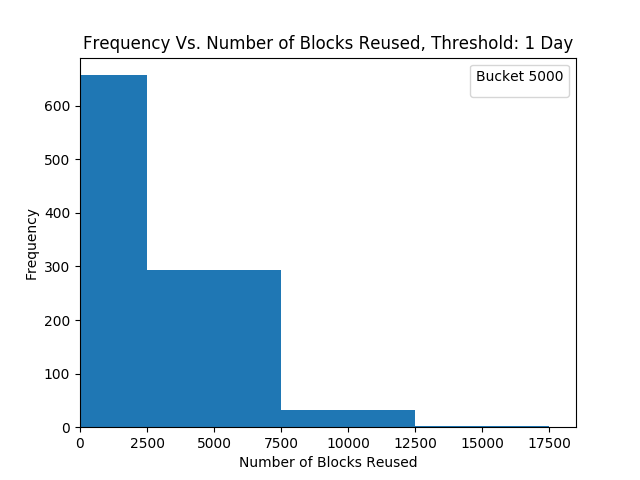

No handles with labels found to put in legend.


In [14]:
fig, ax = plt.subplots(1,1)
bucket = 5000
block_reuse_dict1 = countBlockReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Number of Blocks Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Blocks Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'BlockReuseThreshold1.png')

<IPython.core.display.Javascript object>


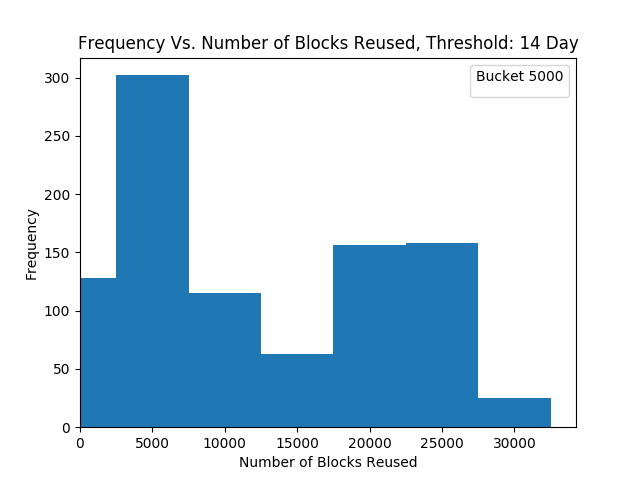

No handles with labels found to put in legend.


In [15]:
fig, ax = plt.subplots(1,1)
bucket = 5000
block_reuse_dict14 = countBlockReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Number of Blocks Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Blocks Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'BlockReuseThreshold14.png')

<IPython.core.display.Javascript object>


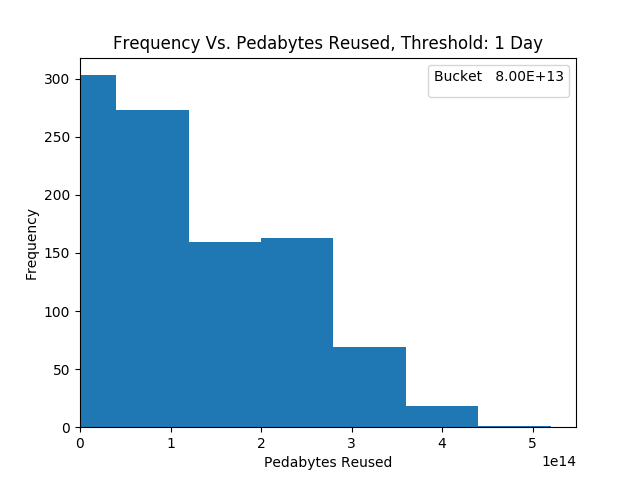

No handles with labels found to put in legend.


In [16]:
fig, ax = plt.subplots(1,1)
bucket = 8*1e13
block_reuse_dict1 = countByteReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Pedabytes Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(format(bucket, "10.2E")))
ax.set_ylabel('Frequency')
ax.set_xlabel('Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteReuseThreshold1.png')

<IPython.core.display.Javascript object>


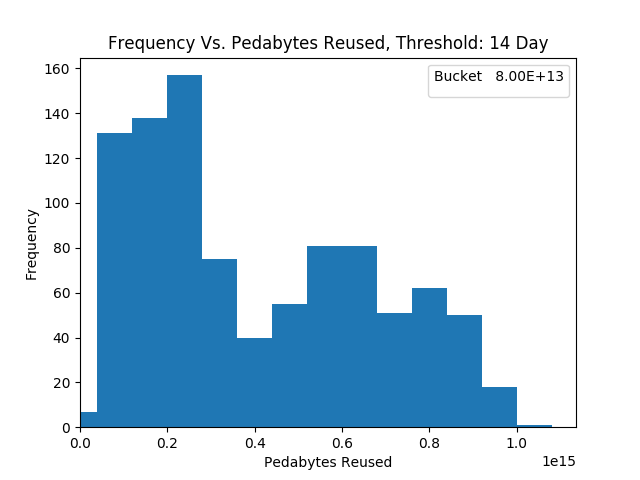

No handles with labels found to put in legend.


In [17]:
fig, ax = plt.subplots(1,1)
bucket = 8*1e13
block_reuse_dict14 = countByteReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Pedabytes Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(format(bucket, "10.2E")))
ax.set_ylabel('Frequency')
ax.set_xlabel('Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteReuseThreshold14.png')

<IPython.core.display.Javascript object>


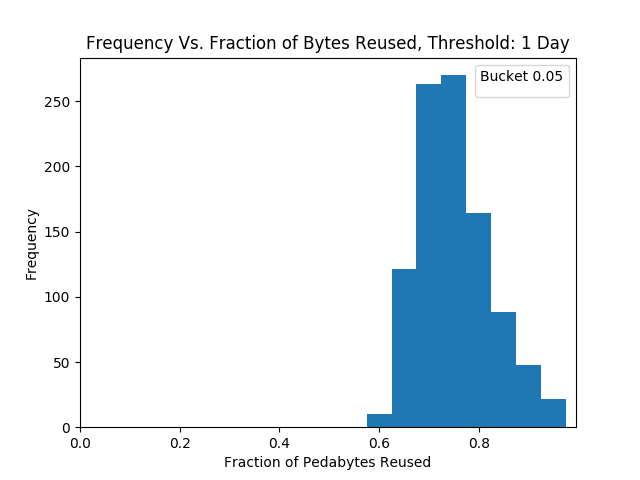

No handles with labels found to put in legend.


In [18]:
fig, ax = plt.subplots(1,1)
bucket = 0.05
block_reuse_dict1 = countByteFracReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Fraction of Bytes Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Fraction of Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteFracReuseThreshold1.png')

<IPython.core.display.Javascript object>


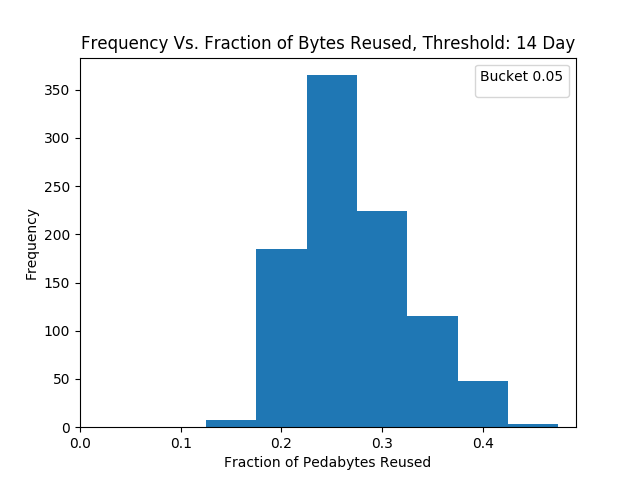

No handles with labels found to put in legend.


In [19]:
fig, ax = plt.subplots(1,1)
bucket = 0.05
block_reuse_dict14 = countByteFracReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Fraction of Bytes Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Fraction of Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig(resultDirectory + 'ByteFracReuseThreshold14.png')

In [20]:
endTime = datetime.datetime.now()
timeDifference = endTime-startTime
print("Total Runtime:")
print(timeDifference)

Total Runtime:
0:01:29.351392


In [21]:
print(ws)

                  day SubmissionTool          input_campaign  d_data_tier_id  \
0        1.453162e+09          crab3                      HC             122   
1        1.453162e+09          crab3   RunIISpring15FSPremix           31224   
2        1.453248e+09          crab3                Run2015B               7   
3        1.453248e+09          crab3                Run2015D               9   
4        1.453334e+09          crab3                Run2015C               9   
5        1.453334e+09          crab3       RunIISpring15DR74              21   
6        1.453421e+09          crab2    RunIIFall15MiniAODv1           31224   
7        1.453421e+09          crab2       RunIISpring15DR74              21   
8        1.453421e+09          crab2  RunIISpring15MiniAODv2           31224   
9        1.453421e+09          crab3    RunIIFall15MiniAODv2           31224   
10       1.453507e+09          crab3                  HCtest             122   
11       1.453507e+09          crab3    

In [22]:
# Finds the number of days total in working_set_day
print("Number of days in working_set_day:")
print(len(list(ws['day'])))
# Finds the number of unique input_campaigns and outputs them
print("Number of unique input_campaigns:")
print(len(list(ws['input_campaign'].unique())))
# Finds the total number of jobs (assuming njobs is the number
# of jobs ran per row)
print("Number jobs total:")
print(ws['njobs'].sum())

Number of days in working_set_day:
1032251
Number of unique input_campaigns:
319
Number jobs total:
604617621
